# Prediction of aging parameters for partial data window

In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)

eSOH_DIR = "../data/esoh/"
oCV_DIR = "../data/ocv/"
fig_DIR = "../figures/"
res_DIR = "../data/results/"
# %matplotlib widget

In [2]:
parameter_values = get_parameter_values()

In [3]:
parameter_values.search("Li")

Cell cooling surface area [m2]	0.41
Initial plated lithium concentration [mol.m-3]	0.0
Inner SEI lithium interstitial diffusivity [m2.s-1]	1e-20
Lithium interstitial reference concentration [mol.m-3]	15.0
Lithium metal partial molar volume [m3.mol-1]	1.3e-05
Lithium plating transfer coefficient	0.7
Ratio of lithium moles to SEI moles	2.0
Typical lithium ion diffusivity [m2.s-1]	5.34e-10
Typical plated lithium concentration [mol.m-3]	1000.0


In [4]:
cell = 1

## Load eSOH Data and OCV Data

In [5]:
cell_no = f'{cell:02d}'
dfe=pd.read_csv(eSOH_DIR+"aging_param_cell_"+cell_no+".csv")
# Remove first RPT
dfe = dfe.drop(dfe.index[0])
dfe = dfe.reset_index(drop=True)
dfe['N']=dfe['N']-dfe['N'][0]
N =dfe.N.unique()
dfo_0=pd.read_csv(oCV_DIR+"ocv_data_cell_"+cell_no+".csv")
print("Cycle Numbers:")
print(*N, sep = ", ") 

Cycle Numbers:
0, 18, 57, 93, 134, 175, 216, 257, 298, 339


In [6]:
dfo = dfo_0[dfo_0['N']==N[0]]
# dfe_0 = dfe[dfe['N']==N[0]]
C_n_init = dfe['C_n'][0]
C_p_init = dfe['C_p'][0]
y_0_init = dfe['y_0'][0] 
if cell_no=='01':
    c_rate_c = 'C/5'
    c_rate_d = 'C/5'
    dis_set = " until 3V"
    # eps_n_data = 0.6234
    # eps_p_data = 0.4542
elif cell_no=='13':
    c_rate_c = 'C/5'
    c_rate_d = 'C/5'
    dis_set = " for 150 min"

In [7]:
dfe.N.iloc[-1]

339

In [8]:
pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")
experiment = pybamm.Experiment(
    [
        ("Discharge at "+c_rate_d+dis_set,
         "Rest for 5 min",
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50")
    ] *dfe.N.iloc[-1],
    termination="50% capacity",
#     cccv_handling="ode",
)
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        # "loss of active material": ("stress-driven","none"),
        "loss of active material": "stress-driven",
        "stress-induced diffusion": "true",
        # "lithium plating": "reversible",
    }
)
# spm.print_parameter_info()

In [9]:
param = spm.param
eps_n_data = parameter_values.evaluate(C_n_init*3600/(param.n.L * param.n.c_max * param.F* param.A_cc))
eps_p_data = parameter_values.evaluate(C_p_init*3600/(param.p.L * param.p.c_max * param.F* param.A_cc))
cs_p_init = parameter_values.evaluate(y_0_init* param.p.c_max)

In [10]:
parameter_values = get_parameter_values()
sim_des = '_lowc'
parameter_values.update(
    {
        "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
        "Positive electrode LAM constant proportional term [s-1]": 8.3569e-6,
        "Negative electrode LAM constant proportional term [s-1]": 5.8032e-5,
        "EC diffusivity [m2.s-1]": 2e-18,
        "Positive electrode LAM constant exponential term": 2,
        "Negative electrode LAM constant exponential term": 2,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
    },
    check_already_exists=False,
)
all_sumvars_dict = cycle_adaptive_simulation(spm, parameter_values, experiment, save_at_cycles=2)

In [11]:
# print(all_sumvars_dict["cycles evaluated"])
# print(all_sumvars_dict["solution time"])

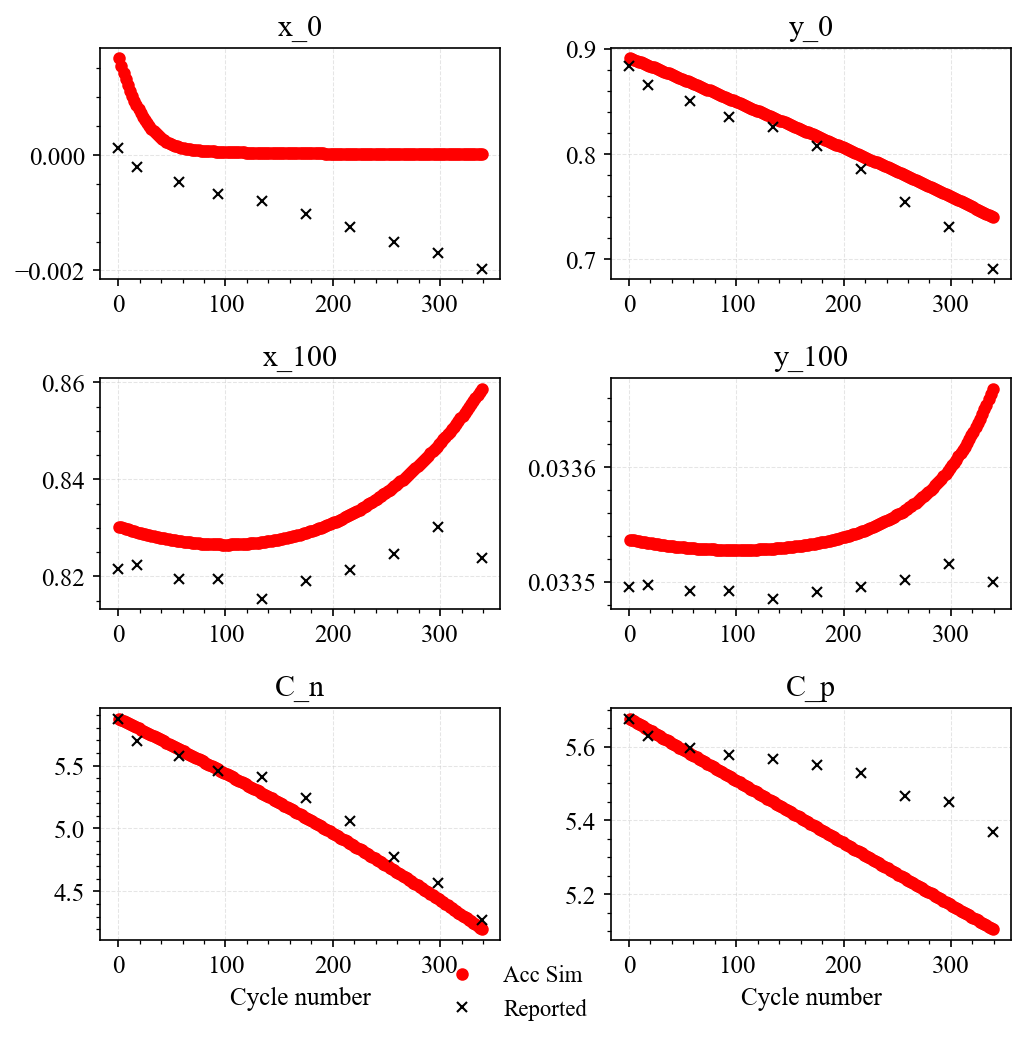

In [12]:
fig = plot(all_sumvars_dict,dfe);
# fig.savefig(fig_DIR +'fast_sim_'+cell_no+'_new.png')

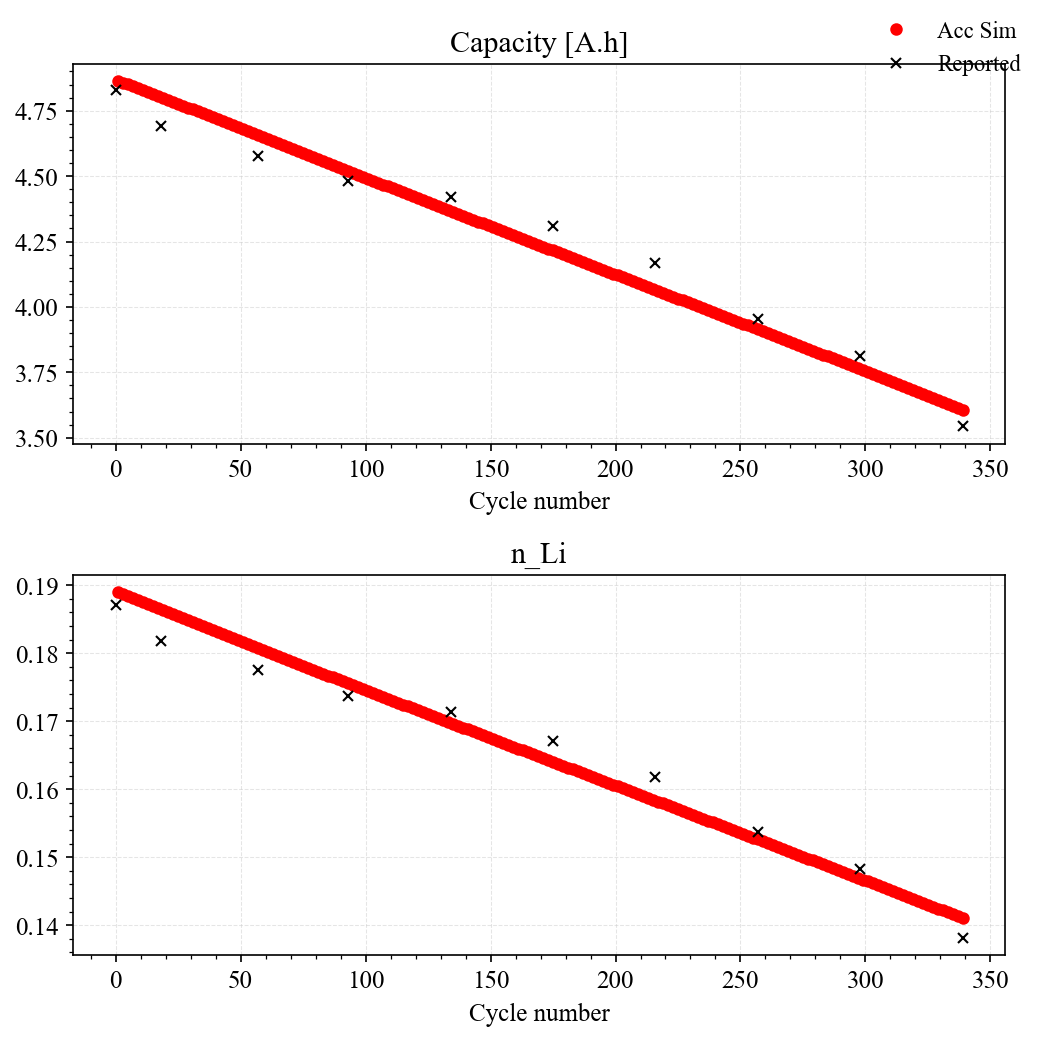

In [13]:
fig = plot1(all_sumvars_dict,dfe);
# fig.savefig(fig_DIR +'fast_sim_'+cell_no+'_cap_new.png')

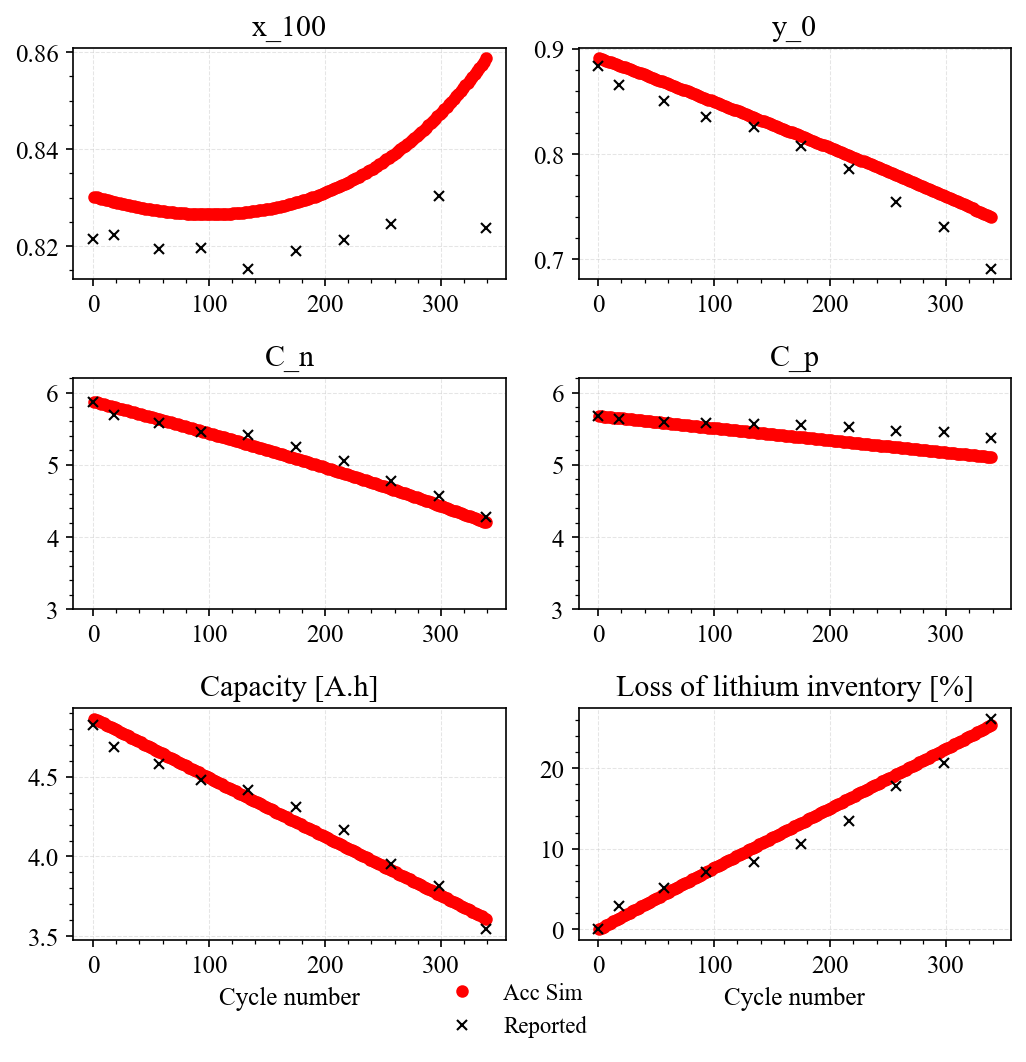

In [14]:
fig = plotc(all_sumvars_dict,dfe);

In [15]:
ddddd

NameError: name 'ddddd' is not defined

# Parameter Fitting

In [ ]:
cycles = np.array(dfe['N'].astype('int'))
cycles=cycles-1
cycles[0]=cycles[0]+1
cycles
dfe['N_mod'] = cycles

In [ ]:
def plot_comp(all_sumvars_dict_0,all_sumvars_dict_1,esoh_data):
    esoh_vars = ["x_100", "y_0", "C_n", "C_p", "Capacity [A.h]", "Loss of lithium inventory [%]"]
    esoh_data["Capacity [A.h]"]=esoh_data["Cap"]
    param = pybamm.LithiumIonParameters()
    esoh_data["n_Li"]= 3600/param.F.value*(esoh_data["y_100"]*esoh_data["C_p"]+esoh_data["x_100"]*esoh_data["C_n"])
    esoh_data["Loss of lithium inventory [%]"]=(1-esoh_data["n_Li"]/esoh_data["n_Li"][0])*100
    fig, axes = plt.subplots(3,2,figsize=(7,7))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(all_sumvars_dict_1["Cycle number"],all_sumvars_dict_1[name],"bo")
        ax.plot(all_sumvars_dict_0["Cycle number"],all_sumvars_dict_0[name],"ro")
        # ax.plot(all_sumvars_dict_1["Cycle number"],all_sumvars_dict_1[name],"bo")
        ax.plot(esoh_data["N"],esoh_data[name],"kx")
        ax.axvline(x = all_sumvars_dict_0["Cycle number"][-1], color = 'm', label = 'axvline - full height')
        ax.set_title(split_long_string(name))
        if k>3:
            ax.set_xlabel("Cycle number")
    fig.legend(["Pred"]+["Train"] + ["Data"], 
           loc="lower center",bbox_to_anchor=[0.5, -0.05], ncol=1, fontsize=11)
    fig.tight_layout()
    return fig

## List of Initial Conditions

In [ ]:
ic = 0
blam_p = [2e-2/3600, 4e-6, 1e-5,1e-6]
blam_n = [2e-1/3600, 3e-5, 2e-5,7e-5]
k_sei= [1.6e-16,1.5e-16,1.7e-16,1.3e-16]

In [ ]:
def objective(model, data):
    return np.array(model.loc[data['N_mod']]["Capacity [A.h]"]) - np.array(data["Cap"])

def multi_objective(model, data):
    variables = ["C_n","C_p","x_100","y_0"]
    # variables = ["Capacity [A.h]", "C_n"]
    weights = [1,1,5,5]
    return np.concatenate([
        (np.array(model.loc[data['N_mod']][var]) - np.array(data[var])) * w
        for w,var in zip(weights,variables)
    ]
    )
@timeoutable()
def simulate(x,expt):
    parameter_values = get_parameter_values()
    parameter_values.update(
        {
            "SEI kinetic rate constant [m.s-1]":  x[2]*k_sei[ic],
            "Positive electrode LAM constant proportional term [s-1]": x[0]* blam_p[ic],
            "Negative electrode LAM constant proportional term [s-1]": x[1]*blam_n[ic],
            "EC diffusivity [m2.s-1]": 2e-18,
            "Positive electrode LAM constant exponential term": 2,
            "Negative electrode LAM constant exponential term": 2,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
        },
        check_already_exists=False,
    )
    Cn = parameter_values.evaluate(param.C_n_init)
    Cp = parameter_values.evaluate(param.C_p_init)
    eps_n = parameter_values["Negative electrode active material volume fraction"]
    eps_p = parameter_values["Positive electrode active material volume fraction"]
    C_over_eps_n = Cn / eps_n
    C_over_eps_p = Cp / eps_p
    return cycle_adaptive_simulation(spm, parameter_values, expt,save_at_cycles=1)
def prediction_error(x,data,expt):
    try:
        model = simulate(x,expt,timeout=60)
        out = multi_objective(pd.DataFrame(model), data)
        print(f"x={x}, norm={np.linalg.norm(out)}")
    # except pybamm.SolverError:
    except:
        out = 10*np.ones_like(np.concatenate([np.array(data['Cap'])]*4))
        print(f"x={x}, norm={np.linalg.norm(out)}")
        return out
    return out
def train_model(data,expt):
    timer = pybamm.Timer()
    x0 = np.array([1.0,1.0,1.0])
    # print(prediction_error(x0))
    soln_dfols = dfols.solve(prediction_error, x0,args=(data,expt), rhoend=1e-3)
    print(timer.time())
    return soln_dfols
def sim_train(dfe,experiment,df,train_len):
    data_train = dfe.iloc[:train_len]
    experiment_train = pybamm.Experiment(
        [
            ("Discharge at "+c_rate_d+dis_set,
            "Rest for 5 min",
            "Charge at "+c_rate_c+" until 4.2V", 
            "Hold at 4.2V until C/50")
        ] *data_train.N.iloc[-1],
        termination="50% capacity",
    #     cccv_handling="ode",
    )
    soln_dfols = train_model(data_train,experiment_train)
    xsol = soln_dfols.x
    # print(xsol[0]*2e-2/3600)
    # print(xsol[1]*2e-1/3600)
    # print(xsol[2]*1.6e-16)
    df['train_len'][train_len-3]=train_len
    df['x_0'][train_len-3]=round(xsol[0],4)
    df['x_1'][train_len-3]=round(xsol[1],4)
    df['x_2'][train_len-3]=round(xsol[2],4)
    # df['obj'][train_len-3]=soln_dfols.f
    try:
        sol_out = simulate(soln_dfols.x,experiment_train,timeout = 60)
        sol_full = simulate(soln_dfols.x,experiment,timeout = 60)
        df['obj'][train_len-3]= np.linalg.norm(prediction_error(soln_dfols.x,data_train,experiment_train))
        df['obj_full'][train_len-3] = np.linalg.norm(prediction_error(soln_dfols.x,dfe,experiment))
        fig = plot_comp(sol_out,sol_full,dfe);
        return df,fig
    except:
        print("Train Len = "+str(train_len)+" failed")
        fig, axes = plt.subplots(3,2,figsize=(7,7))
        return df,fig

In [ ]:
df_x = pd.DataFrame(columns=['train_len','x_0','x_1','x_2','obj','obj_full'], index=range(len(N)+1-3))

Train Length = 3
x=[1. 1. 1.], norm=0.19648843208105707
x=[1.1 1.  1. ], norm=0.19683812748427973
x=[1.  1.1 1. ], norm=0.1853817193501518
x=[1.  1.  1.1], norm=0.19014060526505025
x=[1.00202604 1.16959272 1.07178265], norm=0.17462994118124592
x=[1.0326458  1.29964937 1.44880744], norm=0.14473672064015514
x=[1.35971079 1.3709324  2.09667371], norm=0.12374273705770257
x=[1.26651877 1.31976774 2.14934973], norm=0.12477795989204266
x=[1.31182845 1.47162626 2.10976726], norm=0.12707883451827376
x=[1.35204026 1.37233864 2.1071098 ], norm=0.1237330656994653
x=[1.34347246 1.36902525 2.10125894], norm=0.1237397818023651
x=[1.35403029 1.36219684 2.10993905], norm=0.12376868945765698
x=[1.35286214 1.37261179 2.10901262], norm=0.1237328641525114
x=[1.35195811 1.37260793 2.11010918], norm=0.12373293755524743
x=[1.35383144 1.37279164 2.10981236], norm=0.12373290857504199
x=[1.35274532 1.37365328 2.10891997], norm=0.12373323395374063
x=[1.35286634 1.37259917 2.1090954 ], norm=0.12373286376363349
3 m

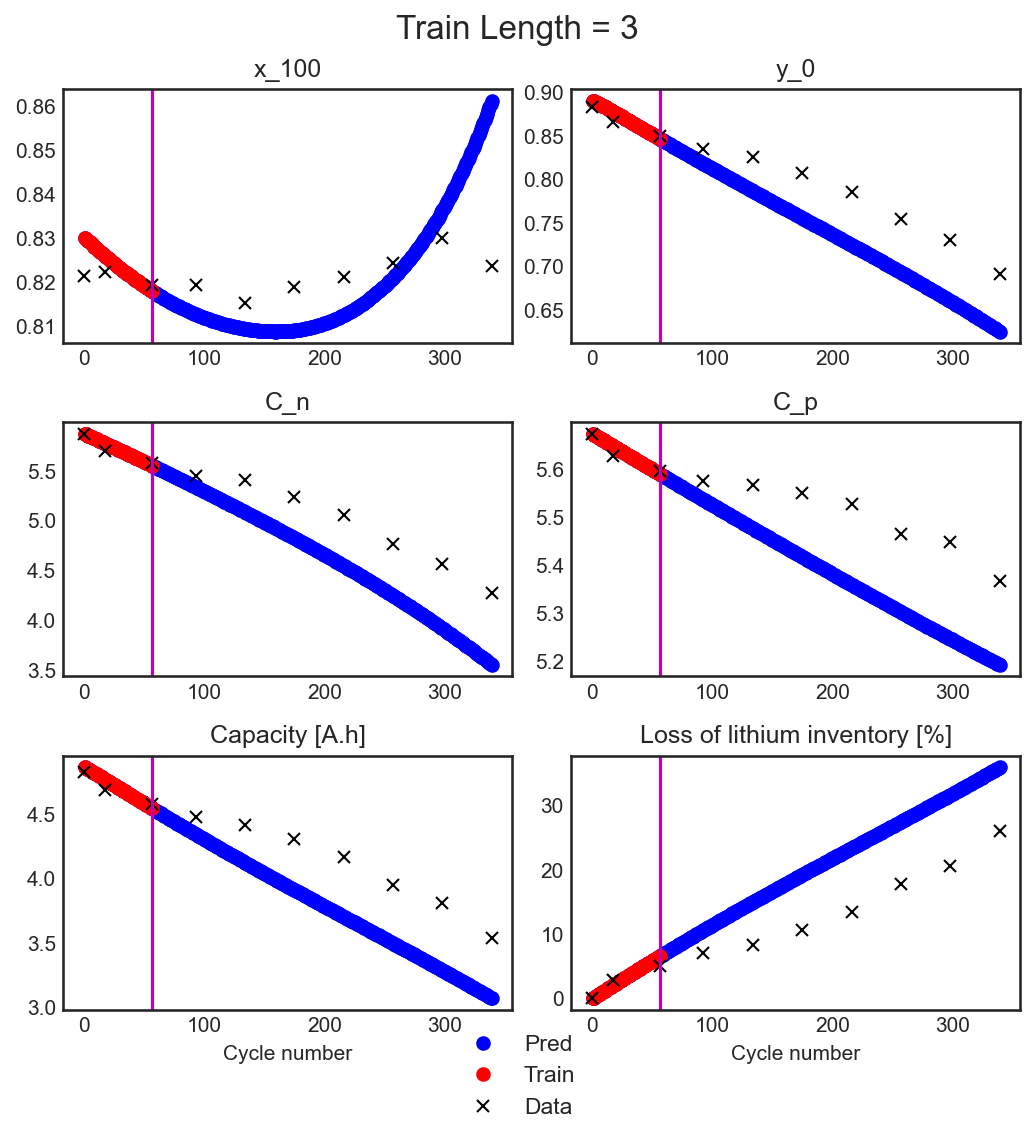

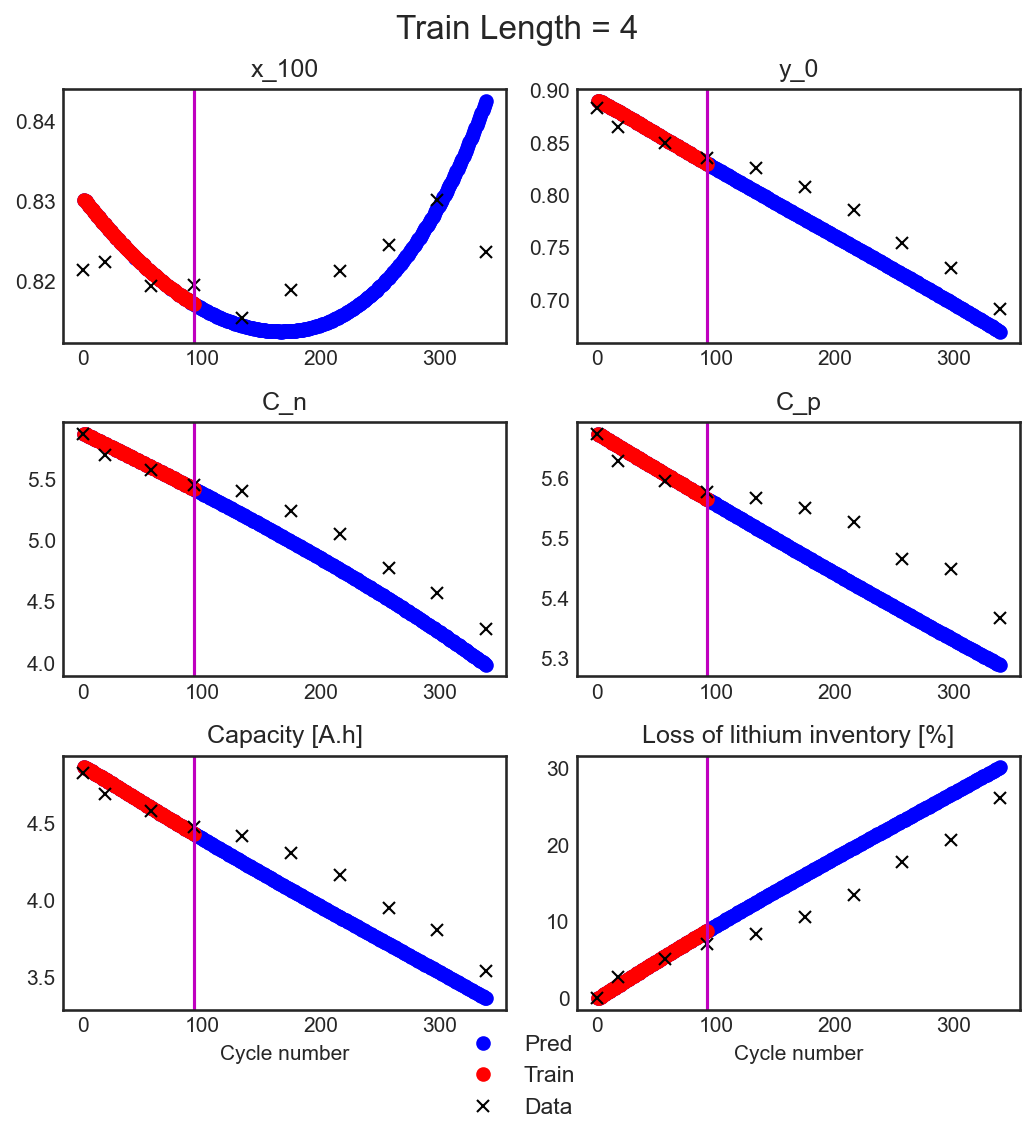

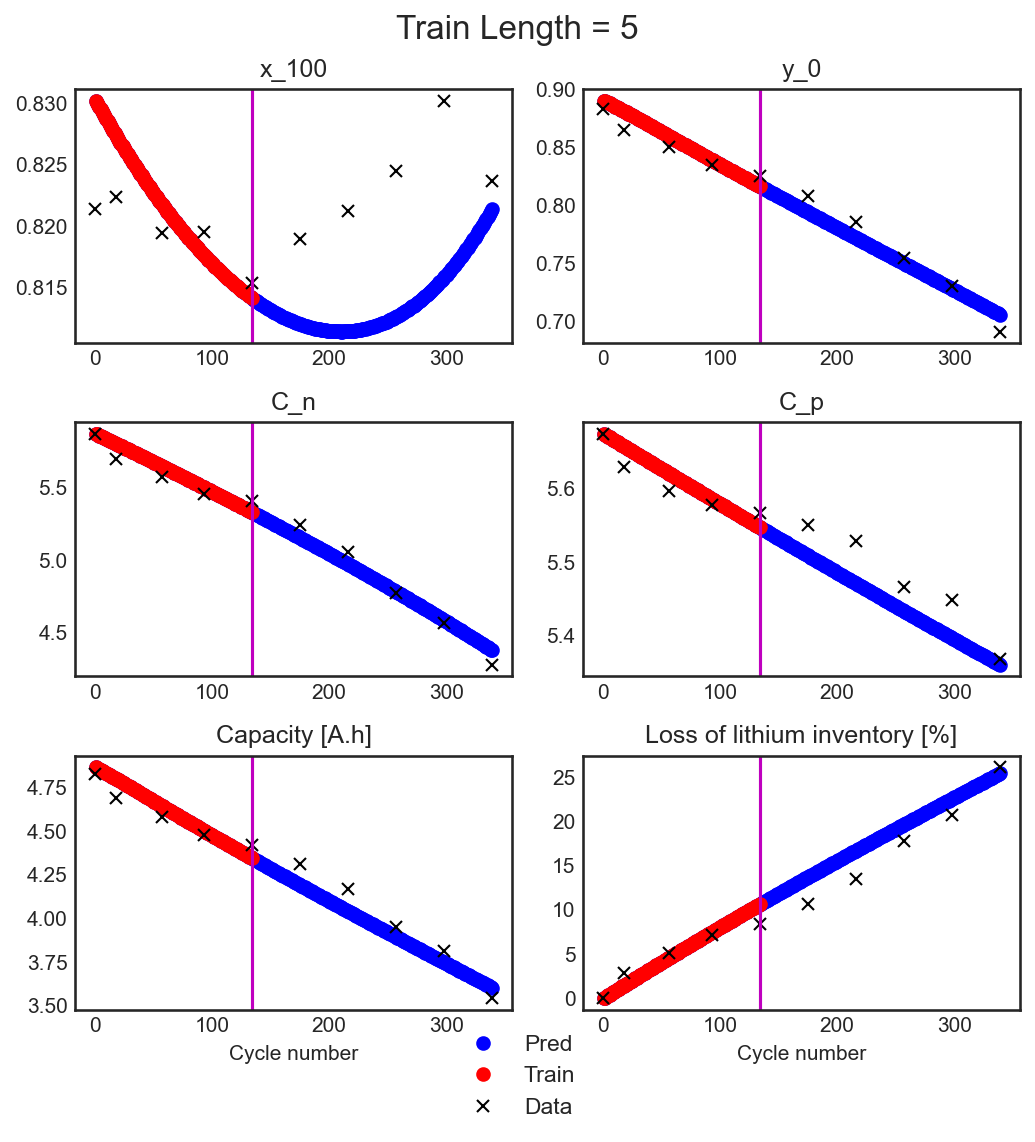

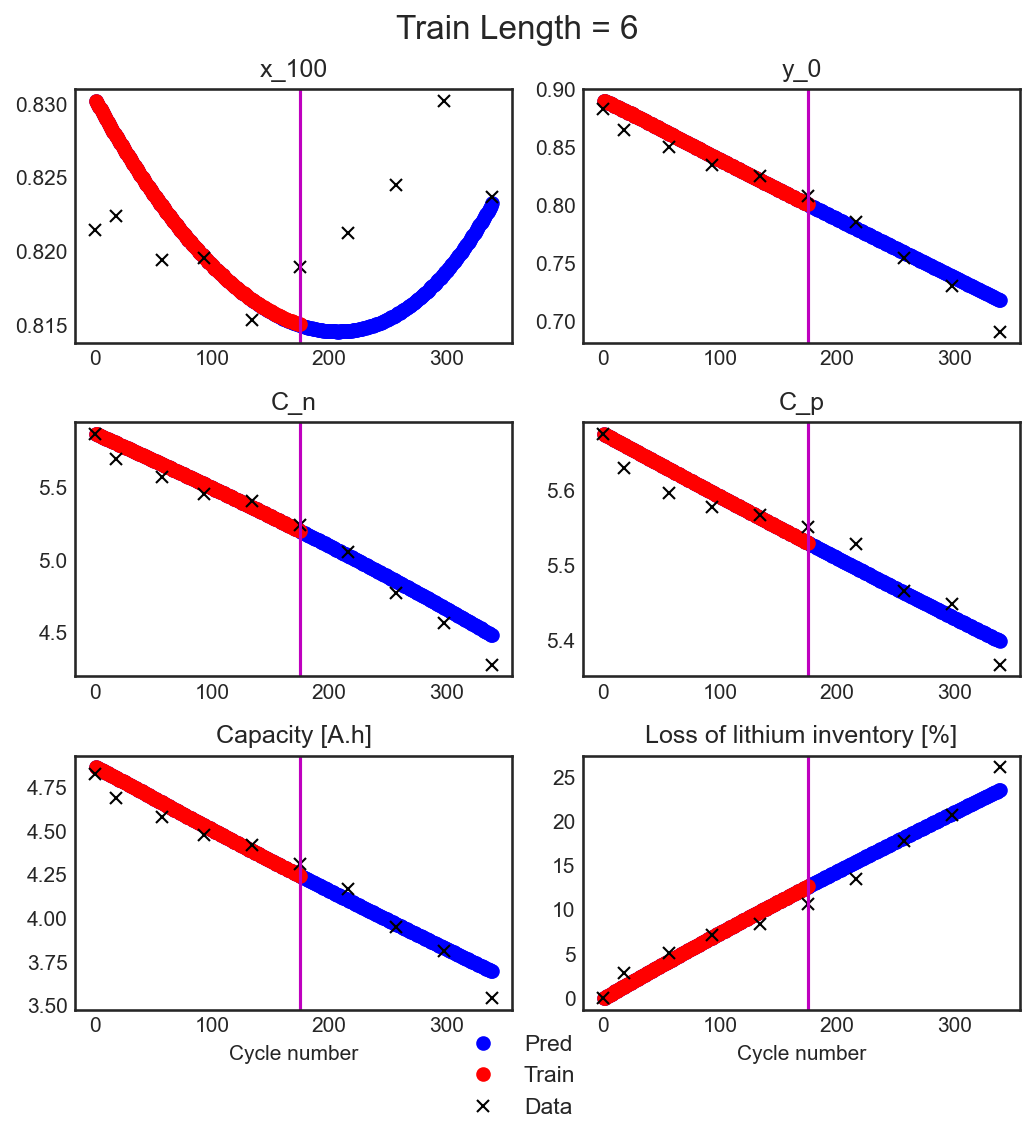

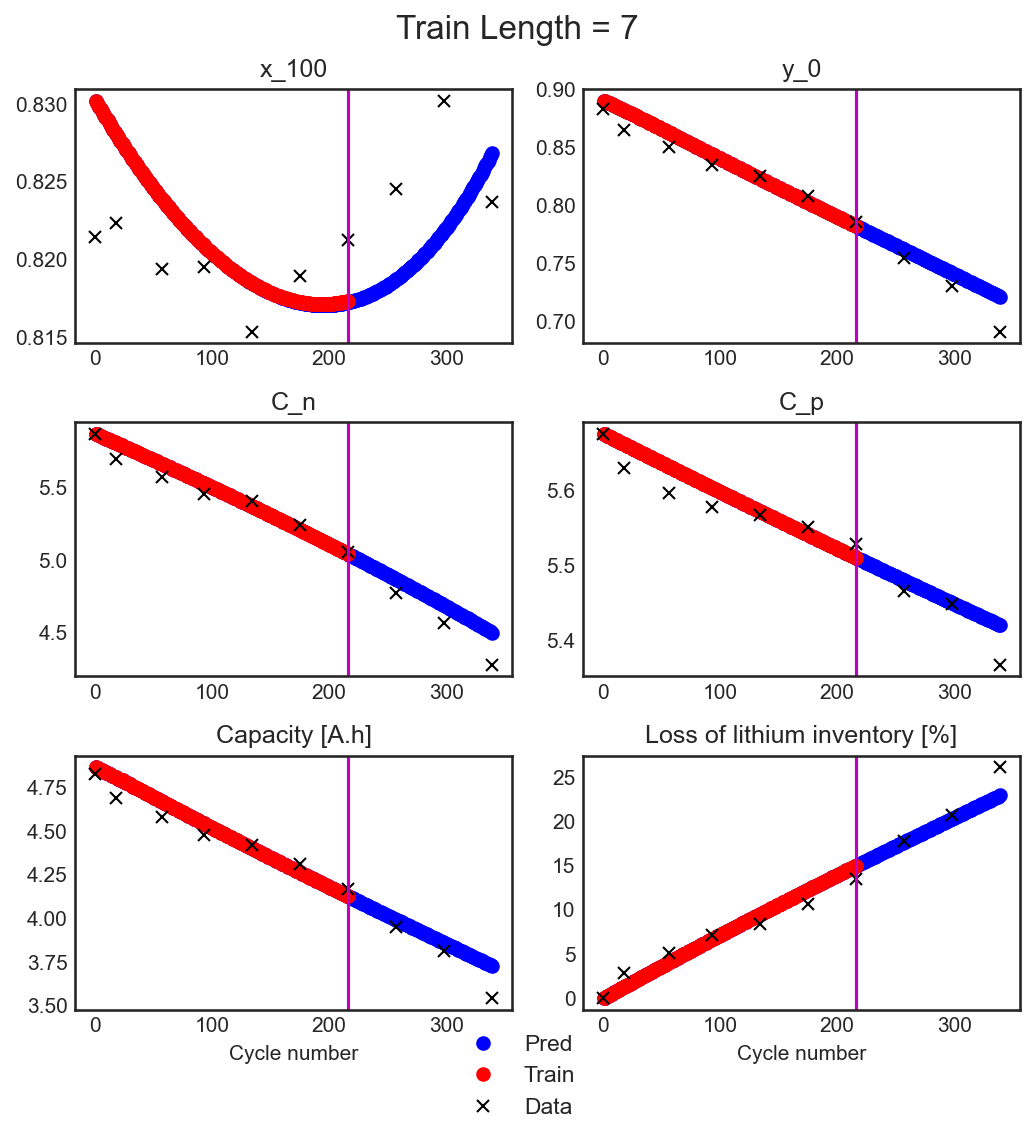

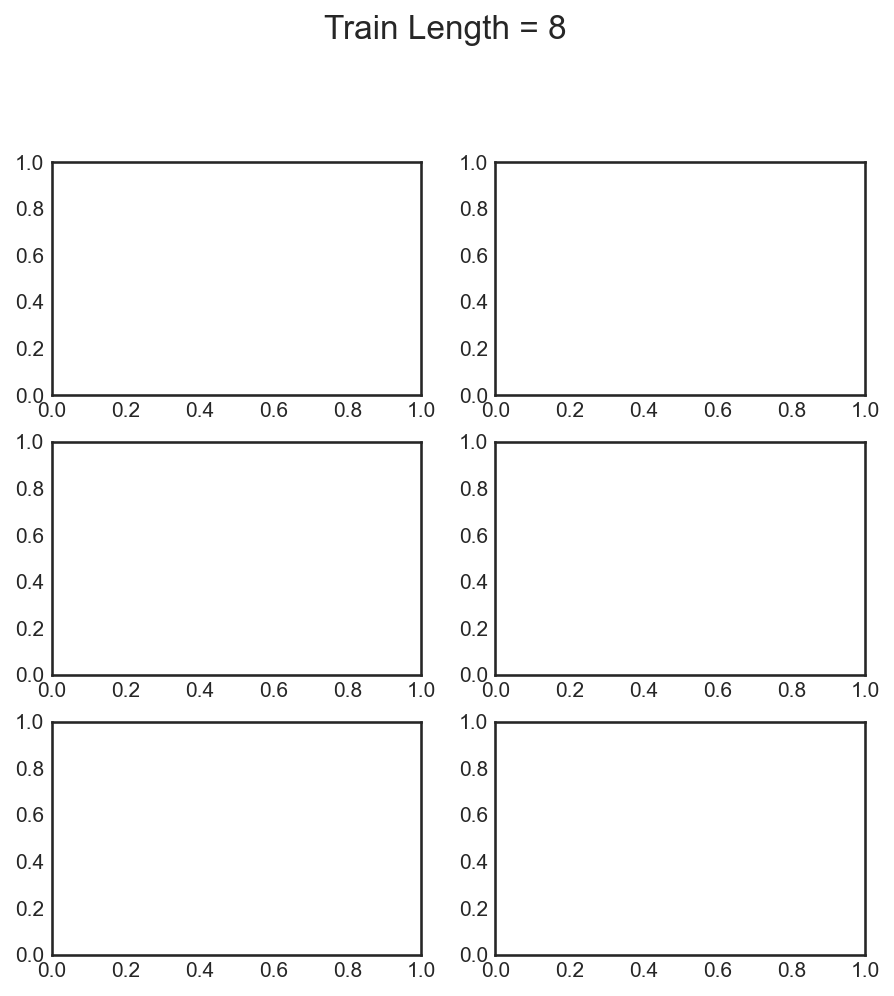

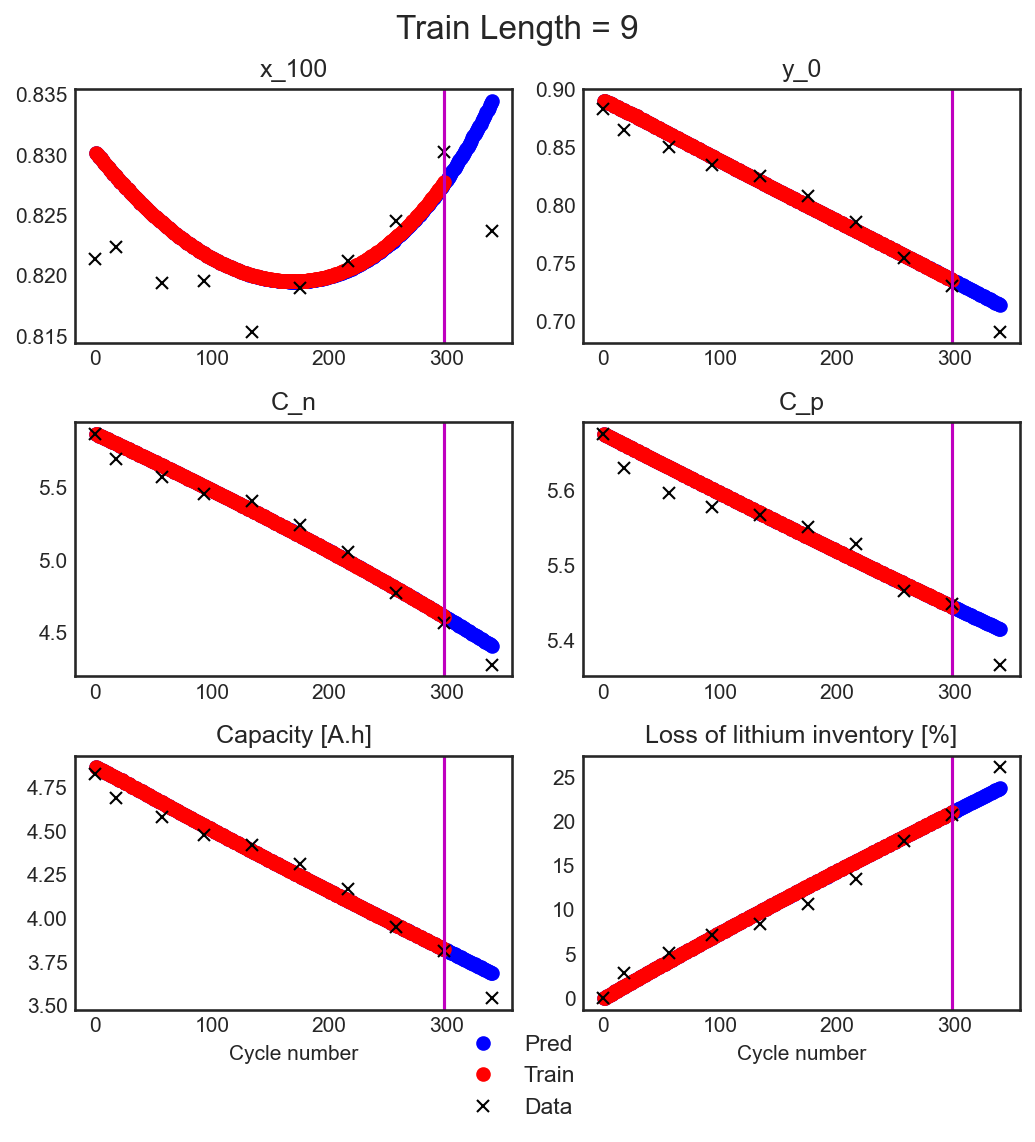

In [ ]:
sim_des = "ic_"+str(ic)
timer1 = pybamm.Timer()
for train_len in range(3,len(N)):
    print("Train Length = {0}".format(train_len))
    df_x,fig = sim_train(dfe,experiment,df_x,train_len)
    # df_x.to_csv(res_DIR + "fit_train_pred_"+sim_des+".csv")
    fig.suptitle('Train Length = '+str(train_len),fontsize=16,y=1.02)
    # fig.savefig(fig_DIR + "fit_train_pred_"+ sim_des+"_"+str(train_len) +"_eSOHC.png",bbox_inches='tight')
    print('Total Time')
    print(timer1.time())

## Generate figures from solutions

In [ ]:
sim_des = "ic_0"
df_x = pd.read_csv(res_DIR + "fit_train_pred_"+sim_des+".csv").drop(['Unnamed: 0'],axis=1)

In [ ]:
df_x =df_x.round(4)

In [ ]:
df_x

In [ ]:
obj =[]
obj_full = []
# for train_len in [8]:
for train_len in range(3,len(N)+1):
    data_train = dfe.iloc[:train_len]
    print(train_len)
    x = [df_x['x_0'][train_len-3],df_x['x_1'][train_len-3],df_x['x_2'][train_len-3]]
    experiment_train = pybamm.Experiment(
            [
                ("Discharge at "+c_rate_d+dis_set,
                "Rest for 5 min",
                "Charge at "+c_rate_c+" until 4.2V", 
                "Hold at 4.2V until C/50")
            ] *data_train.N.iloc[-1],
            termination="50% capacity",
        #     cccv_handling="ode",
        )
    # sol_out = simulate(x,experiment_train,timeout = 30)
    # sol_full = simulate(x,experiment,timeout = 30)
    # fig = plot_comp(sol_out,sol_full,dfe);
    # fig.suptitle('Train Length = '+str(train_len),fontsize=16,y=1.02)
    # fig.savefig(fig_DIR + "fit_train_pred_"+ sim_des+"_"+str(train_len) +"_eSOHC.png",bbox_inches='tight')
    # plt.close(fig)
    df_x['obj'][train_len-3]= np.linalg.norm(prediction_error(x,data_train,experiment_train))
    df_x['obj_full'][train_len-3] = np.linalg.norm(prediction_error(x,dfe,experiment))

In [ ]:
df_x['obj'] = df_x['obj'].astype(float)
df_x['obj_full'] = df_x['obj_full'].astype(float)
df_x =df_x.round(4)
df_x

In [ ]:
df_x.to_csv(res_DIR + "fit_train_pred_"+sim_des+".csv")

## Plot Tuned Parameters

In [ ]:
for ic in range(0,2):
    print(ic)

In [ ]:
for ic in range(0,3):
    sim_des = "ic_"+str(ic)
    df_x = pd.read_csv(res_DIR + "fit_train_pred_"+sim_des+".csv").drop(['Unnamed: 0'],axis=1)
    fig, axes = plt.subplots(3,1,figsize=(7,7))
    ax1 = axes.flat[0]
    ax1.plot(df_x['train_len'],df_x['x_0']*k_sei[ic],'x-')
    ax1.set_title(r'$\beta_{LAM}^+$')
    ax2 = axes.flat[1]
    ax2.plot(df_x['train_len'],df_x['x_1']*blam_p[ic],'x-')
    ax2.set_title(r'$\beta_{LAM}^-$')
    ax3 = axes.flat[2]
    ax3.plot(df_x['train_len'],df_x['x_2']*blam_n[ic],'x-')
    ax3.set_title(r'$\kappa_{SEI}$')
    ax3.set_xlabel('Training Length')
fig.legend(["ic = 0","ic = 1","ic = 2"])
fig.tight_layout()    
fig.savefig(fig_DIR +'trained_parameters_'+sim_des+'.png')

In [ ]:
fig, axes = plt.subplots(3,1,figsize=(7,7))
ax1 = axes.flat[0]
ax1.plot(df_x['train_len'],df_x['x_0']*k_sei[ic],'x-')
ax1.set_title(r'$\beta_{LAM}^+$')
ax2 = axes.flat[1]
ax2.plot(df_x['train_len'],df_x['x_1']*blam_p[ic],'x-')
ax2.set_title(r'$\beta_{LAM}^-$')
ax3 = axes.flat[2]
ax3.plot(df_x['train_len'],df_x['x_2']*blam_n[ic],'x-')
ax3.set_title(r'$\kappa_{SEI}$')
ax3.set_xlabel('Training Length')
fig.tight_layout()
fig.savefig(fig_DIR +'trained_parameters_'+sim_des+'.png')

# Compare with ACC Submission
## Tune only Beta LAM and keep SEI value same as the one in the paper

In [ ]:
def objective(model, data):
    return np.array(model.loc[data['N_mod']]["Capacity [A.h]"]) - np.array(data["Cap"])

def multi_objective(model, data):
    variables = ["C_n","C_p","x_100","y_0"]
    # variables = ["Capacity [A.h]", "C_n"]
    weights = [1,1,5,5]
    return np.concatenate([
        (np.array(model.loc[data['N_mod']][var]) - np.array(data[var])) * w
        for w,var in zip(weights,variables)
    ]
    )
@timeoutable()
def simulate(x,expt):
    parameter_values = get_parameter_values()
    parameter_values.update(
        {
            "SEI kinetic rate constant [m.s-1]":  1.683e-16,
            "Positive electrode LAM constant proportional term [s-1]": x[0]* blam_p[ic],
            "Negative electrode LAM constant proportional term [s-1]": x[1]*blam_n[ic],
            "EC diffusivity [m2.s-1]": 2e-18,
            "Positive electrode LAM constant exponential term": 2,
            "Negative electrode LAM constant exponential term": 2,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
        },
        check_already_exists=False,
    )
    Cn = parameter_values.evaluate(param.C_n_init)
    Cp = parameter_values.evaluate(param.C_p_init)
    eps_n = parameter_values["Negative electrode active material volume fraction"]
    eps_p = parameter_values["Positive electrode active material volume fraction"]
    C_over_eps_n = Cn / eps_n
    C_over_eps_p = Cp / eps_p
    return cycle_adaptive_simulation(spm, parameter_values, expt,save_at_cycles=1)
def prediction_error(x,data,expt):
    try:
        model = simulate(x,expt,timeout=60)
        out = multi_objective(pd.DataFrame(model), data)
        print(f"x={x}, norm={np.linalg.norm(out)}")
    # except pybamm.SolverError:
    except:
        out = 10*np.ones_like(np.concatenate([np.array(data['Cap'])]*4))
        print(f"x={x}, norm={np.linalg.norm(out)}")
        return out
    return out
def train_model(data,expt):
    timer = pybamm.Timer()
    x0 = np.array([1.0,1.0])
    # print(prediction_error(x0))
    soln_dfols = dfols.solve(prediction_error, x0,args=(data,expt), rhoend=1e-3)
    print(timer.time())
    return soln_dfols
def sim_train(dfe,experiment,df,train_len):
    data_train = dfe.iloc[:train_len]
    experiment_train = pybamm.Experiment(
        [
            ("Discharge at "+c_rate_d+dis_set,
            "Rest for 5 min",
            "Charge at "+c_rate_c+" until 4.2V", 
            "Hold at 4.2V until C/50")
        ] *data_train.N.iloc[-1],
        termination="50% capacity",
    #     cccv_handling="ode",
    )
    soln_dfols = train_model(data_train,experiment_train)
    xsol = soln_dfols.x
    # print(xsol[0]*2e-2/3600)
    # print(xsol[1]*2e-1/3600)
    # print(xsol[2]*1.6e-16)
    df['train_len'][train_len-3]=train_len
    df['x_0'][train_len-3]=round(xsol[0],4)
    df['x_1'][train_len-3]=round(xsol[1],4)
    df['x_2'][train_len-3]=1
    # df['obj'][train_len-3]=soln_dfols.f
    try:
        sol_out = simulate(soln_dfols.x,experiment_train,timeout = 60)
        sol_full = simulate(soln_dfols.x,experiment,timeout = 60)
        df['obj'][train_len-3]= np.linalg.norm(prediction_error(soln_dfols.x,data_train,experiment_train))
        df['obj_full'][train_len-3] = np.linalg.norm(prediction_error(soln_dfols.x,dfe,experiment))
        fig = plot_comp(sol_out,sol_full,dfe);
        return df,fig
    except:
        print("Train Len = "+str(train_len)+" failed")
        fig, axes = plt.subplots(3,2,figsize=(7,7))
        return df,fig

In [ ]:
df_x = pd.DataFrame(columns=['train_len','x_0','x_1','x_2','obj','obj_full'], index=range(len(N)+1-3))

In [ ]:
N

array([  0,  18,  57,  93, 134, 175, 216, 257, 298, 339], dtype=int64)

In [ ]:
for train_len in range(len(N),len(N)+1):
    print(train_len)

10


Train Length = 10
x=[1. 1.], norm=0.5095087463967373
x=[1.1 1. ], norm=0.539352564892128
x=[1.  1.1], norm=0.7429989619766131
x=[0.91070613 0.95498217], norm=0.4597427164083958
x=[0.73046752 0.94326372], norm=0.4382053516923487
x=[0.73800795 0.93029677], norm=0.4419413229554376
x=[0.72257915 0.94453432], norm=0.4381644344085708
x=[0.72687698 0.9447119 ], norm=0.4381553026790657
x=[0.72680595 0.94643103], norm=0.43821193858747276
x=[0.72635283 0.94455975], norm=0.4381548781651701
x=[0.72635132 0.9445597 ], norm=0.43815487799357394
3 minutes, 21 seconds
x=[0.72635132 0.9445597 ], norm=0.43815487799357394
x=[0.72635132 0.9445597 ], norm=0.43815487799357394
Total Time
4 minutes, 35 seconds


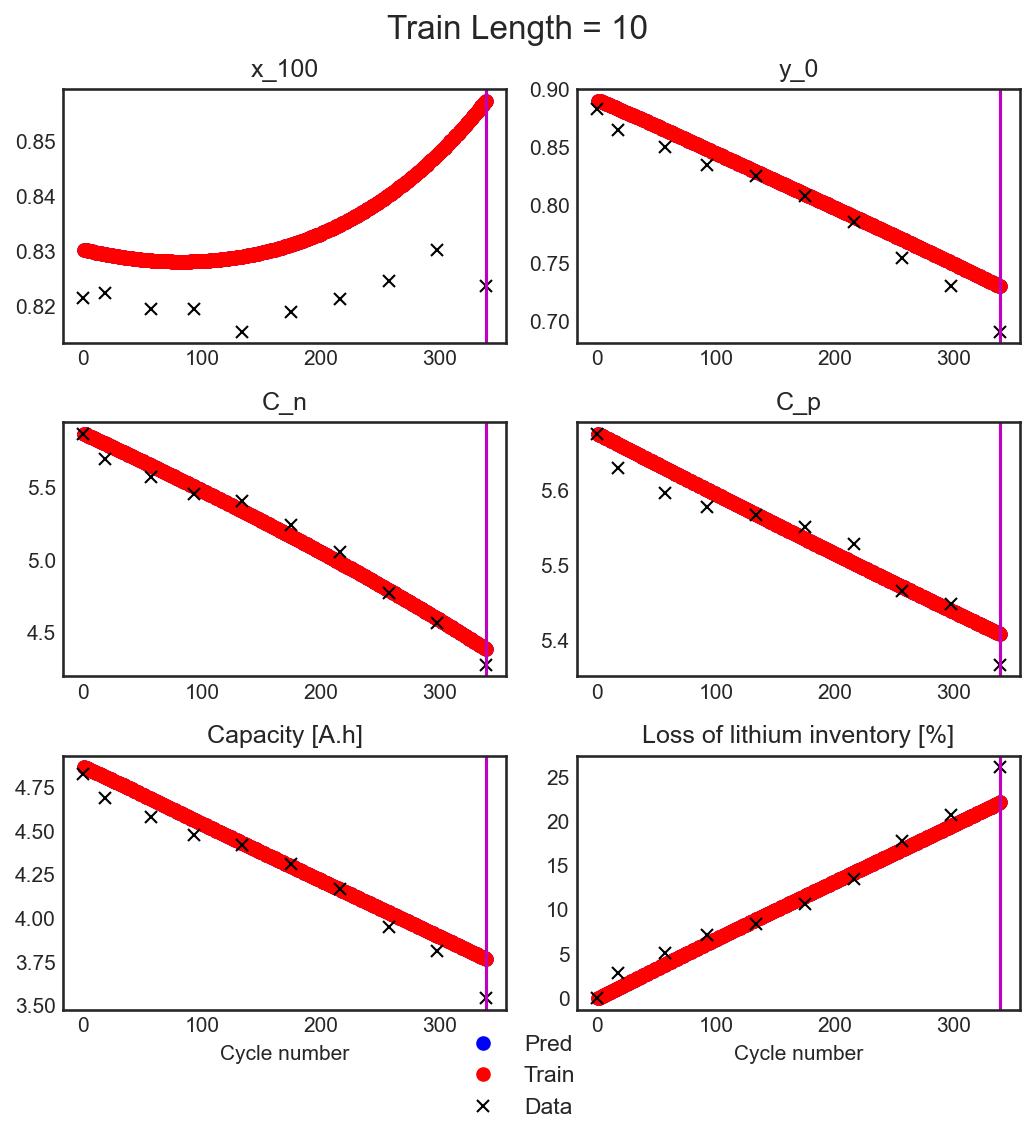

In [ ]:
ic=0
sim_des = "acc_ic_"+str(ic)
timer1 = pybamm.Timer()
for train_len in range(3,len(N)+1):
    print("Train Length = {0}".format(train_len))
    df_x,fig = sim_train(dfe,experiment,df_x,train_len)
    df_x.to_csv(res_DIR + "fit_train_pred_"+sim_des+".csv")
    fig.suptitle('Train Length = '+str(train_len),fontsize=16,y=1.02)
    fig.savefig(fig_DIR + "fit_train_pred_"+ sim_des+"_"+str(train_len) +"_eSOHC.png",bbox_inches='tight')
    print('Total Time')
    print(timer1.time())